# Part 4: Recurrent Neural Network

### In this section, the cleaned text will be vectorized using TF-IDF (covered in Part 2) and will be used to train a Support Vector Machine (SVM). Specifically, the model used is the sklearn LinearSVC for classification problems.

### This section will also explore and test different methods of fine-tuning the SVM and evaluating its effectiveness

In [ ]:
import sys
!{sys.executable} -m pip install pandas_profiling
!{sys.executable} -m pip install spacy
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install imblearn
!{sys.executable} -m pip install scikit-learn-intelex
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m spacy download en_core_web_md


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import spacy
import nltk
import re
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
tf.__version__
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer

adasyn=ADASYN()
sb.set()

""" NOTE: SET YOUR PROJECT ROOT DIRECTORY HERE """
PROJ_DIR = r""
RANDOM_SPLIT_SEED = 11
MAX_FEATURES = 50000
MAX_LEN = 50

This section has been copied over from Part 2. It vectorizes the processed text and splits train/test data. In this case, the max features are limited to 25000 because of computing power needed otherwise (default is 1M+ params)

In [2]:
### SECTION COPIED FROM PART 2, PLEASE REFER TO DESCRIPTION FOUND THERE

df = pd.read_csv(PROJ_DIR + r"\sc1015-project\dataset\fake_job_postings.csv")

cleaned_text = pd.read_csv('lemmatized_text.csv').squeeze() # convert to pd series


Here we will use one-hot encoding instead of TF-IDF, to be used for the RNN.

In [3]:
one_hot_text = [one_hot(words,MAX_FEATURES)for words in cleaned_text] 

In [4]:
ml_seq = pad_sequences(one_hot_text,padding='pre',maxlen=MAX_LEN)

In [9]:
sss=StratifiedShuffleSplit(n_splits=1, random_state=RANDOM_SPLIT_SEED, test_size=0.2)
X=np.zeros(shape=ml_seq.shape[0],dtype=np.bool_)
y=np.array(df['fraudulent']) # prediction target
for train_index, test_index in sss.split(X, y):
    X_train, X_test = ml_seq[train_index,:], ml_seq[test_index,:]
    y_train, y_test = y[train_index], y[test_index]


This section has also been copied over from Part 2. It uses ADASYN to oversample the minority class (i.e frauduent=true). SMOTE was attempted but was not as good.

In [12]:
X_res, y_res = adasyn.fit_resample(X_train, y_train)


#smote = SMOTE(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [13]:
X_res[1]

array([ 5991, 46386, 32485,  4591, 10160,  5028, 27782, 10515, 24171,
       42323,  5991, 30273,  7861, 12030, 18762,  1084,  4605, 20188,
       45451, 37733,  9974, 19495,  1084, 47311, 12521, 27087,  4064,
       28762, 12011, 26162, 12521, 28762,  7436, 33446, 43673,  7122,
       27825, 40105, 23751, 26426, 15781, 14716, 45700, 14541, 15781,
       13470, 14136, 48724, 15215, 16983])

In [74]:
def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch // batch_size
    counter = 0
    index = np.arange(X_data.shape[0])
    while True:
        index_batch = index[batch_size * counter:batch_size * (counter + 1)]
        X_batch = X_data[index_batch]
        y_batch = y_data[index_batch]
        counter += 1
        yield X_batch, y_batch
        if counter > number_of_batches:
            counter = 0
model = Sequential()
model.add(Embedding(MAX_FEATURES, 40, input_length=MAX_LEN))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 50, 40)            2000000   
                                                                 
 bidirectional_14 (Bidirecti  (None, 256)              173056    
 onal)                                                           
                                                                 
 dense_25 (Dense)            (None, 64)                16448     
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                     

Epoch 1/10
426/426 [==============================] - 69s 155ms/step - loss: 0.2133 - accuracy: 0.9196 - val_loss: 0.1094 - val_accuracy: 0.9704
Epoch 2/10
426/426 [==============================] - 102s 240ms/step - loss: 0.0667 - accuracy: 0.9753 - val_loss: 0.1338 - val_accuracy: 0.9732
Epoch 3/10
426/426 [==============================] - 103s 242ms/step - loss: 0.0405 - accuracy: 0.9804 - val_loss: 0.1335 - val_accuracy: 0.9648
Epoch 4/10
426/426 [==============================] - 101s 238ms/step - loss: 0.0309 - accuracy: 0.9832 - val_loss: 0.2913 - val_accuracy: 0.9676
Epoch 5/10
426/426 [==============================] - 102s 239ms/step - loss: 0.0221 - accuracy: 0.9850 - val_loss: 0.2977 - val_accuracy: 0.9572
Epoch 6/10
426/426 [==============================] - 102s 239ms/step - loss: 0.0273 - accuracy: 0.9849 - val_loss: 0.2968 - val_accuracy: 0.9706
Epoch 7/10
426/426 [==============================] - 102s 239ms/step - loss: 0.0257 - accuracy: 0.9844 - val_loss: 0.2813 - 

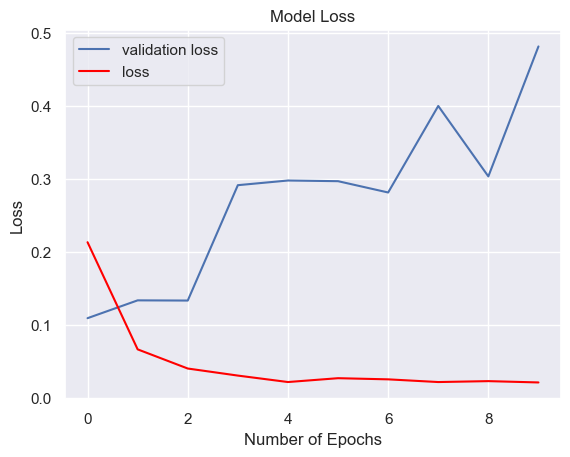

In [75]:
hist = model.fit(X_res,y_res,validation_data=(X_test,y_test),epochs=10,batch_size=64)
plt.plot(hist.history['val_loss'], color='b', label="validation loss")
plt.plot(hist.history['loss'], color='red', label="loss")
plt.title("Model Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [76]:
test_probs = model.predict(X_test, batch_size=64)
test_preds = (test_probs >= 0.5).astype(int)

test_accuracy = accuracy_score(y_test, test_preds)

print(f"RNN test accuracy score : {test_accuracy}")

56/56 [==============================] - 3s 49ms/step
RNN test accuracy score : 0.973434004474273


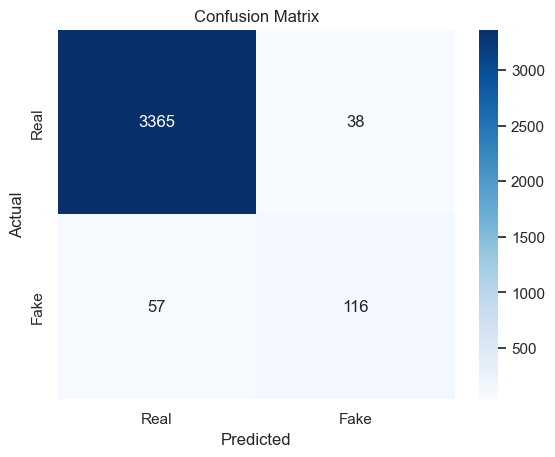

True Positive Rate: 0.6705202312138728
True Negative Rate: 0.9888333823097267
False Positive Rate: 0.011166617690273288
False Negative Rate: 0.32947976878612717
Accuracy: 0.973434004474273
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3403
           1       0.75      0.67      0.71       173

    accuracy                           0.97      3576
   macro avg       0.87      0.83      0.85      3576
weighted avg       0.97      0.97      0.97      3576



In [77]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, test_preds)

# Define the class labels
class_names = ['Real', 'Fake']

# Create a heatmap of the confusion matrix
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Set the axis labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

TPR = TP / (TP + FN)
print("True Positive Rate:", TPR)
TNR = TN / (TN + FP) 
print("True Negative Rate:", TNR)
FPR = FP / (FP + TN)
print("False Positive Rate:", FPR)
FNR = FN / (TP + FN)
print("False Negative Rate:", FNR)
ACC = (TP + TN) / (TP + FP + FN + TN)
print("Accuracy:", ACC)

print(metrics.classification_report(y_test, test_preds))